<a href="https://colab.research.google.com/github/Fadiabdf/OPT/blob/main/TP1/OPT_tp_PVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP1 OPT  siq1 : problème de voyageur de commerce , branch & bound


In [ ]:
!pip install tsplib95
!pip install springpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: networkx
    Found existing installation: networkx 3.5
    Uninstalling networkx-3.5:
      Successfully uninstalled networkx-3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; pl

# **Pseudo algorithme Branch and Bound pour le PVC (TSP)**

    Fonction BranchAndBound_TSP(matrice_distances):
    Initialiser une file de priorité (heap) pour stocker les nœuds
    Initialiser la meilleure solution avec un coût infini et un chemin vide
    Calculer la borne initiale pour le nœud racine
    Ajouter le nœud racine à la file de priorité

    Tant que la file de priorité n'est pas vide:
        Extraire le nœud avec la plus petite borne
        Si la borne du nœud est supérieure au meilleur coût actuel:
            Continuer (ignorer ce nœud)
        Si le nœud représente une solution complète:
            Calculer le coût total du chemin
            Si ce coût est meilleur que le meilleur coût actuel:
                Mettre à jour la meilleure solution
        Sinon:
            Pour chaque ville non visitée:
                Créer un nouveau nœud en ajoutant cette ville au chemin
                Calculer la nouvelle borne pour ce nœud
                Si la nouvelle borne est prometteuse:
                    Ajouter le nouveau nœud à la file de priorité

    Retourner la meilleure solution (coût optimal et chemin optimal)

# **l'espace de recherche est :**
(nb_noeuds-1)! /2

car le probleme est

 **symétrique** (distance ij = distance ji) et **cyclique** (revenir au noeud de départ)

 Pour un ensemble de n villes, le nombre total de circuits possibles est **(n - 1)! / 2**. Cette réduction s'explique par le fait que, dans un circuit fermé, le point de départ est arbitraire, et chaque circuit peut être parcouru dans deux sens (horaire et antihoraire), ce qui divise le nombre total de permutations par 2.


# **Structures de données utilisées**


**Représentation du problème :**

**Matrice de distances :** Une matrice
n
×
n
n×n où chaque élément
d
[
i
]
[
j
]
 représente la distance entre la ville
i
i et la ville
j
j.

**Nœud :** Une structure qui contient :

**visite :** Un masque binaire pour indiquer les villes visitées.

**actuel :** La dernière ville visitée.

**cout :** Le coût actuel du chemin.

**borne :** La borne inférieure pour ce nœud.

**chemin :** Le chemin partiel parcouru jusqu'à présent.

# **Représentation de la solution :**

**Meilleure solution :** Une structure qui contient :

**cout_optimal :** Le coût minimal trouvé.

**chemin_optimal :** La séquence des villes à visiter.

# **Autres structures**

**File de priorité :** Une structure de type tas (heap) pour stocker les nœuds à explorer, triés par leur borne.

**DataFrame pour stocker les résultats :**

Une structure DataFrame pour enregistrer les résultats de chaque instance testée :

**Instance :** Le nom de l'instance testée.

**Cout_Optimal :** Le coût optimal trouvé.

**Chemin_Optimal :** Le chemin optimal.

**Temps_Execution :** Le temps d'exécution en secondes.

# **PVC Branch & Bound implémentation**

# **Approche pour implémenter Branch and Bound**
**Initialisation :**

Calculer les deux plus petites arêtes sortantes pour chaque ville (pour la borne initiale).

Initialiser la file de priorité avec le nœud racine (ville de départ).

**Exploration :**

Extraire le nœud avec la plus petite borne.

Si le nœud représente une solution complète, mettre à jour la meilleure solution.

Sinon, générer de nouveaux nœuds en ajoutant des villes non visitées et les ajouter à la file de priorité si leur borne est prometteuse.

**Élagage :**

Ignorer les nœuds dont la borne est supérieure au meilleur coût actuel.

**Terminaison :**

Retourner la meilleure solution lorsque la file de priorité est vide.

In [ ]:
# imports
import heapq
import time
import numpy as np
from math import ceil
import xml.etree.ElementTree as ET
import tsplib95
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

In [ ]:
class Noeud:
    __slots__ = ('visite', 'actuel', 'cout', 'borne', 'chemin')

    def __init__(self, visite, actuel, cout, borne, chemin):
        self.visite = visite  # Bitmask des villes visitées
        self.actuel = actuel  # Dernière ville visitée
        self.cout = cout      # Coût actuel du chemin
        self.borne = borne    # Borne inférieure pour ce nœud
        self.chemin = chemin  # Chemin partiel (pour débogage)

    def __lt__(self, autre):
        # comparer deux nœuds par leur borne (utilisé dans la file de priorité)
        return self.borne < autre.borne


def calculer_aretes_minimales(matrice_distances):
    """
    Prépare une liste contenant les deux plus petites distances sortantes pour chaque ville.
    Cela aide à calculer rapidement la borne inférieure.
    """
    n = len(matrice_distances)
    aretes_minimales = []
    for i in range(n):
        # Récupère toutes les distances de la ville i vers les autres villes
        distances = [matrice_distances[i][j] for j in range(n) if i != j]
        distances.sort()  # Trie les distances par ordre croissant
        # Garde les deux plus petites distances
        aretes_minimales.append((distances[0], distances[1] if len(distances) > 1 else distances[0]))
    return aretes_minimales


def calculer_borne(actuel, visite, cout, aretes_minimales, matrice_distances, n):
    """
    Calcule la borne inférieure pour un nœud donné en utilisant les deux plus petites arêtes non utilisées.
    La borne est une estimation du coût minimal pour compléter le chemin.
    """
    borne = cout
    # Parcourt toutes les villes
    for ville in range(n):
        # Si la ville n'a pas encore été visitée
        if not (visite & (1 << ville)):
            # Ajoute la moyenne des deux plus petites arêtes de cette ville à la borne
            borne += (aretes_minimales[ville][0] + aretes_minimales[ville][1]) / 2
    return ceil(borne)  # Arrondit la borne à l'entier supérieur pour éviter les comparaisons flottantes



In [ ]:
def branch_and_bound_tsp_opt(matrice_distances, timeout=300):

    n = len(matrice_distances)
    aretes_minimales = calculer_aretes_minimales(matrice_distances)
    meilleur_cout = float('inf')
    meilleur_chemin = []

    # 1- Initialisation avec une heuristique gloutonne (Plus Proche Voisin)
    ville_depart = 0
    chemin_actuel = [ville_depart]
    visite = 1 << ville_depart  # Marque la ville de départ comme visitée
    cout_actuel = 0

    while len(chemin_actuel) < n:
        derniere_ville = chemin_actuel[-1]
        ville_suivante = -1
        distance_min = float('inf')

        # Trouve la ville la plus proche non visitée
        for ville in range(n):
            if not (visite & (1 << ville)) and matrice_distances[derniere_ville][ville] < distance_min:
                distance_min = matrice_distances[derniere_ville][ville]
                ville_suivante = ville

        if ville_suivante == -1:
            break  # Si aucune ville n'est trouvée, arrête

        chemin_actuel.append(ville_suivante)
        visite |= 1 << ville_suivante  # Marque la ville comme visitée
        cout_actuel += distance_min

    # Ajoute le coût pour revenir à la ville de départ
    cout_actuel += matrice_distances[chemin_actuel[-1]][ville_depart]
    meilleur_cout = cout_actuel
    meilleur_chemin = chemin_actuel[:]

    # 2- Initialisation de la file de priorité
    file_priorite = []
    borne_initiale = calculer_borne(0, 1 << 0, 0, aretes_minimales, matrice_distances, n)
    heapq.heappush(file_priorite, Noeud(1 << 0, 0, 0, borne_initiale, [0]))
    debut_temps = time.time()

    # 3- Exploration des nœuds
    while file_priorite:
        # Vérifie si le temps maximal est dépassé
        if time.time() - debut_temps > timeout:
            print("Timeout atteint. Meilleure solution trouvée jusqu'à présent.")
            break

        noeud = heapq.heappop(file_priorite)

        # Si la borne du nœud est supérieure au meilleur coût actuel, on l'ignore
        if noeud.borne >= meilleur_cout:
            continue

        # Si toutes les villes ont été visitées, on calcule le coût total
        if bin(noeud.visite).count('1') == n:
            cout_total = noeud.cout + matrice_distances[noeud.actuel][0]
            if cout_total < meilleur_cout:
                meilleur_cout = cout_total
                meilleur_chemin = noeud.chemin + [0]
            continue

        # Explore les villes non visitées
        for ville_suivante in range(n):
            if not (noeud.visite & (1 << ville_suivante)):
                nouvelle_visite = noeud.visite | (1 << ville_suivante)
                nouveau_cout = noeud.cout + matrice_distances[noeud.actuel][ville_suivante]
                nouvelle_borne = calculer_borne(ville_suivante, nouvelle_visite, nouveau_cout, aretes_minimales, matrice_distances, n)

                # Si la nouvelle borne est prometteuse, on ajoute le nœud à la file
                if nouvelle_borne < meilleur_cout:
                    nouveau_chemin = noeud.chemin + [ville_suivante]
                    heapq.heappush(file_priorite, Noeud(nouvelle_visite, ville_suivante, nouveau_cout, nouvelle_borne, nouveau_chemin))

    return meilleur_cout, meilleur_chemin

# **Importer les fichiers de test et extraction de la matrices de distances**

**vérifier que  les fichiers du test (*.xml | *.tsp) sont bien importés:**

In [ ]:
!ls

berlin52.xml  sample_data


# **les deux fichiers que nous avons testé tester en variant le nombre des noeuds**
Capture d’écran 2025-02-27 230127.png

**Extraire la matrice des distances de fichier test  (*.xml)**

In [ ]:
#------------------------------------------------------------------------
# Charger et parser le fichier XML
instance = ('berlin52.xml')
problem = ET.parse(instance)
#------------------------------------------------------------------------
root = problem.getroot()  # la racine du fichier XML

# Dictionnaire pour stocker les données du graphe
graphe = {}

# Parcourir les sommets du graphe
for i, sommet in enumerate(root.find('graph').findall('vertex')):
    aretes = {}
    # Parcourir les arêtes du sommet actuel
    for arete in sommet.findall('edge'):
        cible = int(arete.text)  # ID du sommet cible
        cout = float(arete.get('cost'))
        aretes[cible] = cout
    graphe[i] = aretes  # Ajoute les arêtes au sommet correspondant


nombre_sommets = len(graphe)
print(f"Nombre de nœuds : {nombre_sommets}")

# Initialiser une matrice de distances avec des valeurs infinies
matrice_distances = np.full((nombre_sommets, nombre_sommets), np.inf)
matrice_distances = matrice_distances.astype(int)  # Convertit en entiers

# Remplir la matrice de distances avec les coûts extraits
for i, aretes in graphe.items():
    for j, cout in aretes.items():
        matrice_distances[i, j] = cout

# Définir la diagonale à zéro (distance d'un sommet à lui-même)
np.fill_diagonal(matrice_distances, 0)

# Sélectionner un sous-ensemble de la matrice pour les tests
#------------------------------------------------------------------------
n_sous_ensemble = 15#nombre_sommets  # Nombre de sommets à inclure dans le sous-ensemble
print(f"Nombre de nœuds à prendre pour le test : {n_sous_ensemble}")
sous_ensemble_matrice = matrice_distances[:n_sous_ensemble, :n_sous_ensemble]
#------------------------------------------------------------------------

# Convertir la matrice en liste pour une utilisation ultérieure
matrice_distances_liste = matrice_distances.tolist()
sous_ensemble_matrice_liste = sous_ensemble_matrice.tolist()

# Afficher le sous-ensemble de la matrice
print(sous_ensemble_matrice)




Nombre de nœuds : 52
Nombre de nœuds à prendre pour le test : 15
[[   0  666  281  395  291  326  640  426  600  561 1040  655  975 1120
   299]
 [ 666    0  649 1047  945  978   45  956 1134 1132 1638 1258 1440 1515
   957]
 [ 281  649    0  603  508  542  610  308  485  487 1266  891 1247 1399
   504]
 [ 395 1047  603    0  104   69 1026  525  611  533  663  294  711  897
   100]
 [ 291  945  508  104    0   35  923  470  583  513  760  382  769  944
    25]
 [ 326  978  542   69   35    0  957  491  596  523  726  349  744  922
    40]
 [ 640   45  610 1026  923  957    0  918 1095 1095 1627 1245 1440 1521
   935]
 [ 426  956  308  525  470  491  918    0  183  180 1144  812 1234 1414
   452]
 [ 600 1134  485  611  583  596 1095  183    0   83 1165  873 1316 1507
   561]
 [ 561 1132  487  533  513  523 1095  180   83    0 1082  792 1236 1428
   490]
 [1040 1638 1266  663  760  726 1627 1144 1165 1082    0  387  442  619
   762]
 [ 655 1258  891  294  382  349 1245  812  873  792  38

<ipython-input-8-9f32c971ce0e>:27: RuntimeWarning: invalid value encountered in cast
  matrice_distances = matrice_distances.astype(int)  # Convertit en entiers


**afficher a subset de la matrice des distances extraite**

# **Visualisation du graphe de l'instance (*.xml) à tester**

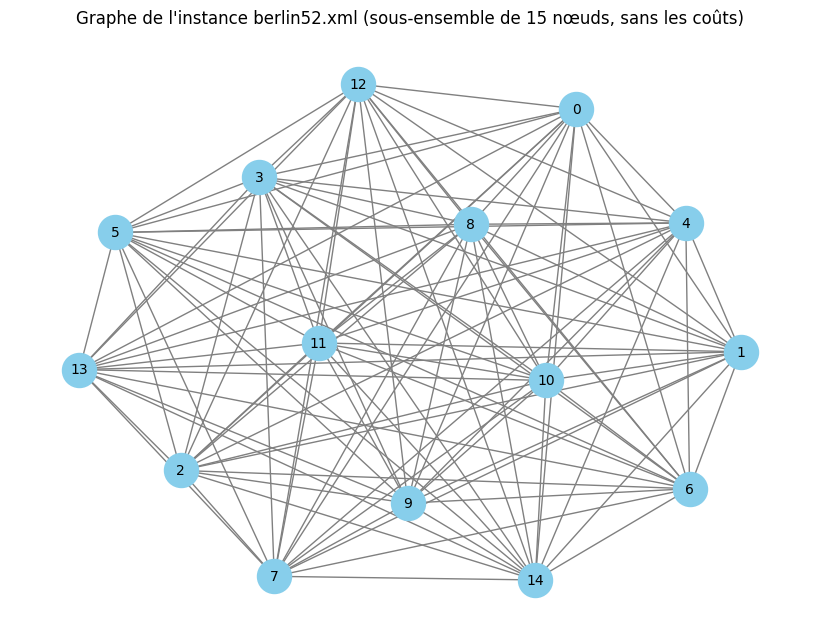

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Création du graphe depuis la matrice du sous-ensemble
G = nx.Graph()

# Ajouter les arêtes du sous-ensemble, sans tenir compte des poids
for i in range(len(sous_ensemble_matrice_liste)):
    for j in range(i+1, len(sous_ensemble_matrice_liste[i])):
        if sous_ensemble_matrice_liste[i][j] != 0 and sous_ensemble_matrice_liste[i][j] != np.inf:
            G.add_edge(i, j)

# Générer une disposition automatique (spring layout)
pos = nx.spring_layout(G, seed=42)  # seed pour fixer la disposition

# Affichage du graphe
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=600, font_size=10)
plt.title(f"Graphe de l'instance {instance} (sous-ensemble de {len(G.nodes)} nœuds, sans les coûts)")
plt.axis("off")
plt.show()


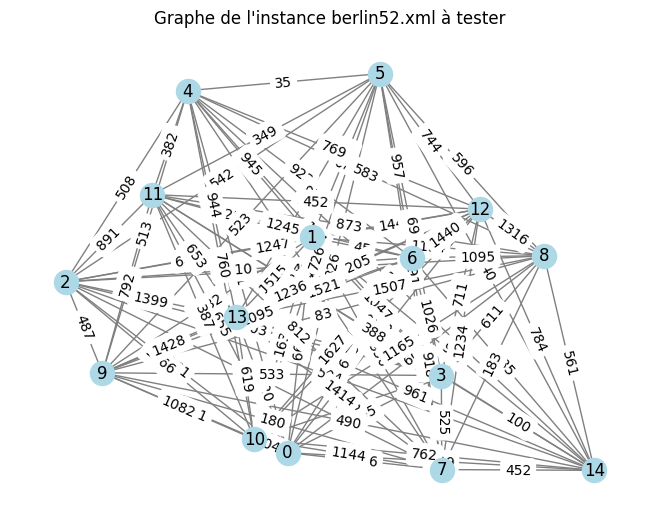

In [ ]:
import networkx as nx

# Créer un graphe à partir de la matrice de distances
G = nx.Graph()
for i in range(len(sous_ensemble_matrice_liste)):
    for j in range(len(sous_ensemble_matrice_liste[i])):
        if i != j:
            G.add_edge(i, j, weight= sous_ensemble_matrice_liste[i][j])

# Dessiner le graphe
pos = nx.spring_layout(G)  # Positionnement des nœuds
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Graphe de l'instance " +instance+ " à tester")
plt.show()

# **les TESTS**

 # **TEST avec une matrice de notre choix simple**

In [ ]:
# Matrice de distances exemple simple de notre choix
matrice_distances = [
    [0, 10, 15, 20, 0, 10, 15, 20],
    [10, 0, 35, 25, 10, 0, 35, 25],
    [15, 35, 0, 30, 15, 35, 0, 30],
    [20, 25, 30, 0, 20, 25, 30, 0],
    [0, 10, 15, 20, 0, 10, 15, 20],
    [10, 0, 35, 25, 10, 0, 35, 25],
    [15, 35, 0, 30, 15, 35, 0, 30],
    [20, 25, 30, 0, 20, 25, 30, 0]
]

cout_optimal, chemin_optimal = branch_and_bound_tsp_opt(matrice_distances)

print("Coût optimal :", cout_optimal)
print("Chemin optimal :", chemin_optimal)

Coût optimal : 80
Chemin optimal : [0, 1, 3, 2]
Temps d'exécution: 0.000116 secondes


# **TEST avec un fichier test (*.xml)**

In [ ]:
start_time = time.time()
cout_optimal, chemin_optimal = branch_and_bound_tsp_opt(sous_ensemble_matrice_liste)
end_time = time.time()

temps_execution = end_time - start_time

print("Instance urilisée : " + instance)
print("Coût optimal :", cout_optimal)
print("Chemin optimal :", chemin_optimal)
print("Temps d'exécution : {:.6f} secondes".format(temps_execution))

Instance urilisée : berlin52.xml
Coût optimal : 4962
Chemin optimal : [0, 1, 6, 2, 7, 8, 9, 14, 4, 5, 3, 11, 10, 12, 13, 0]
Temps d'exécution : 60.235101 secondes


# **le résultats des fichiers de test (*.xml) :**



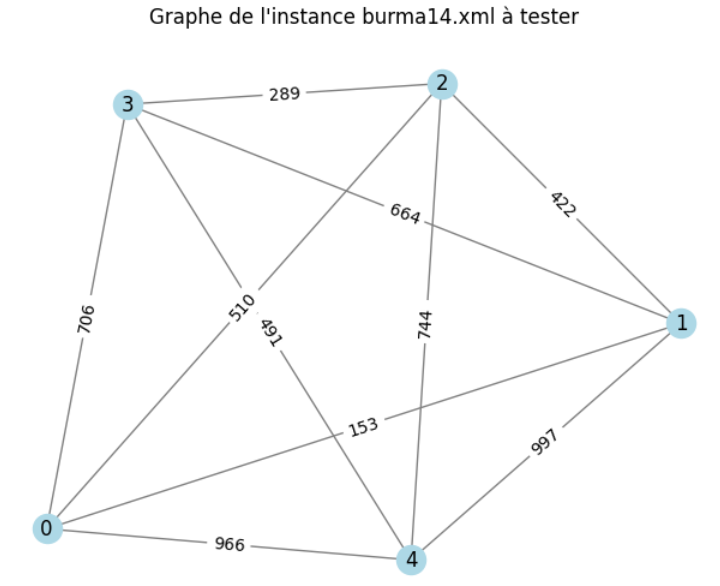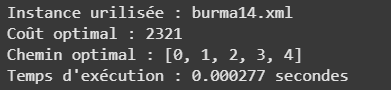



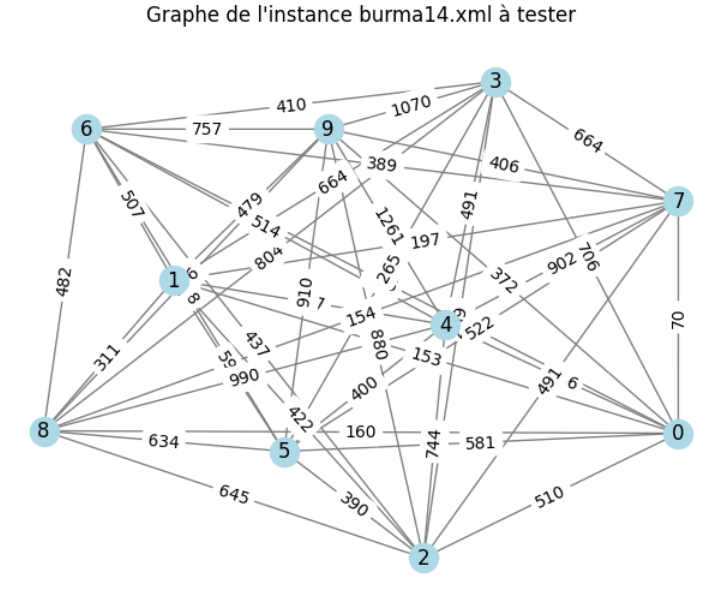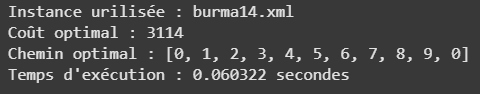

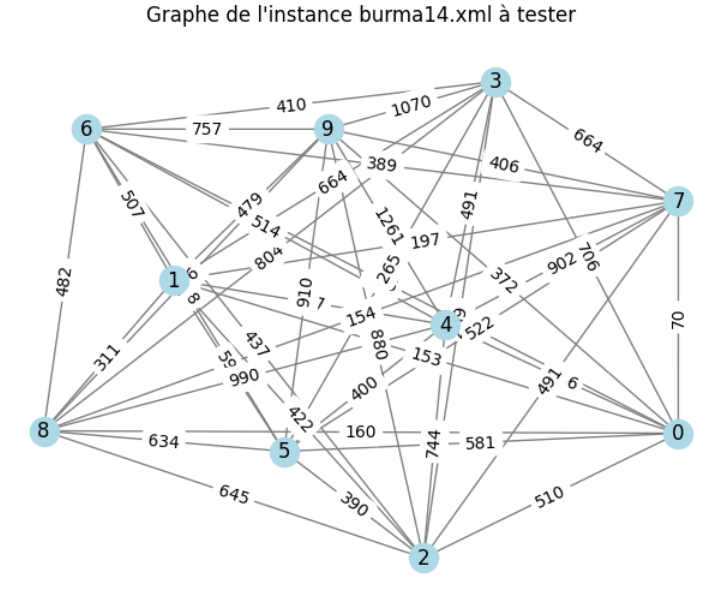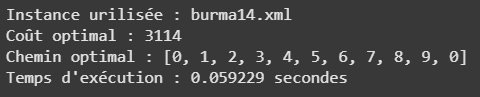

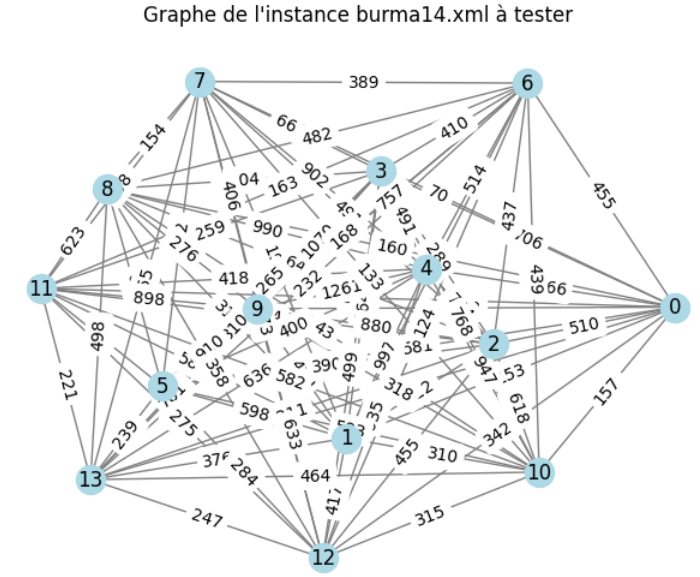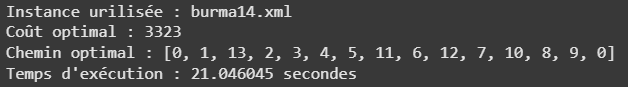

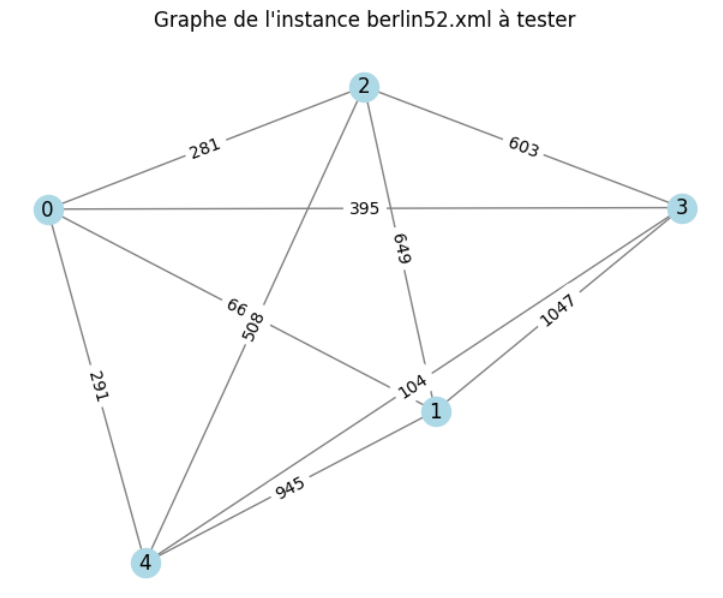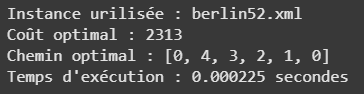

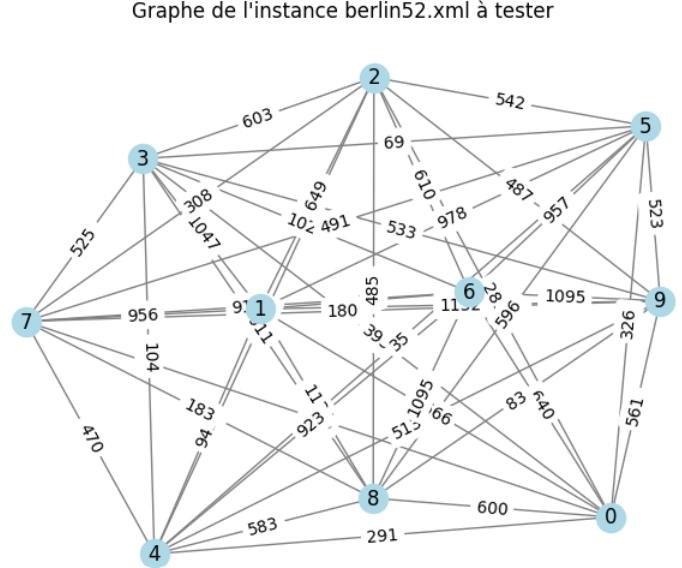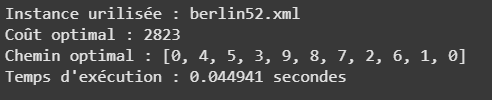

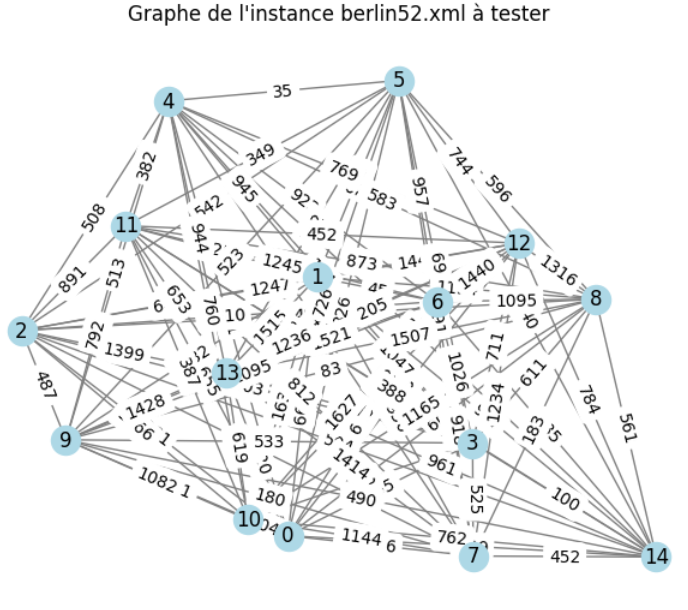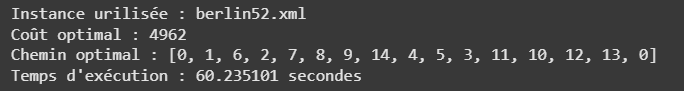

# **Des tests sur d'autres fichiers**

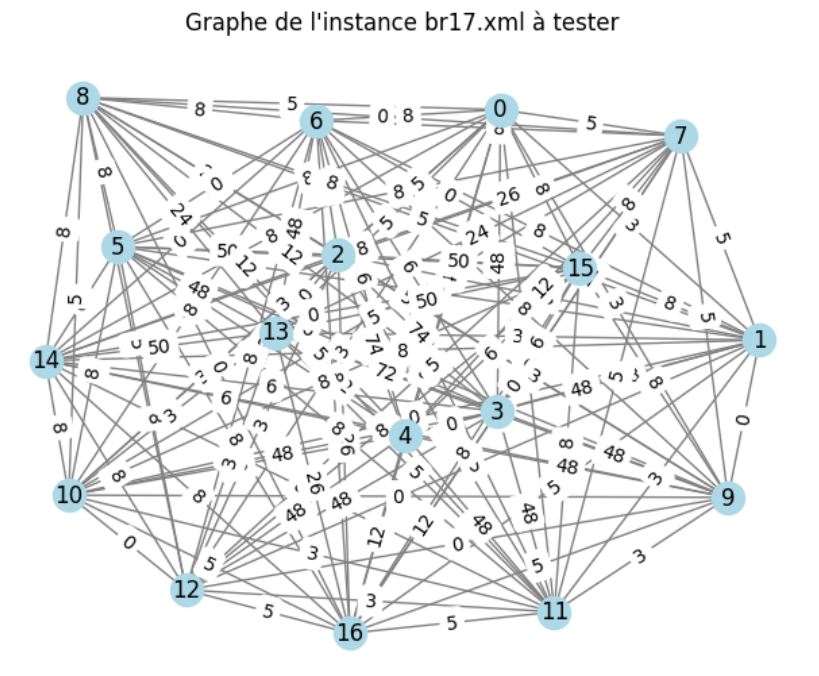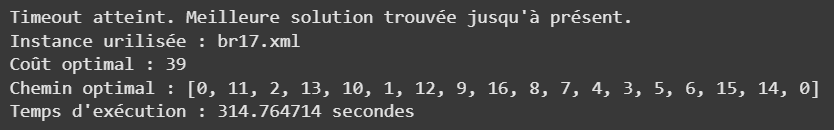

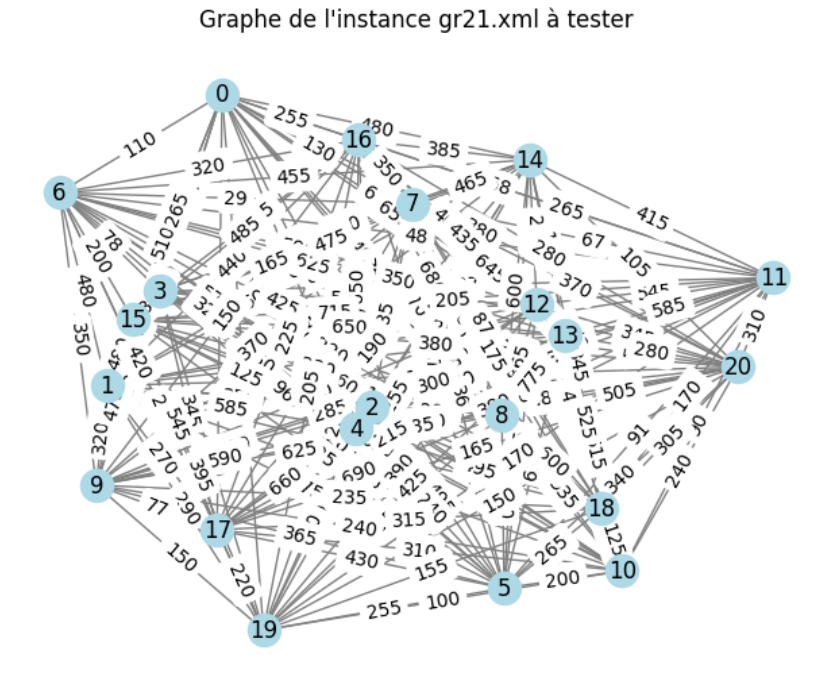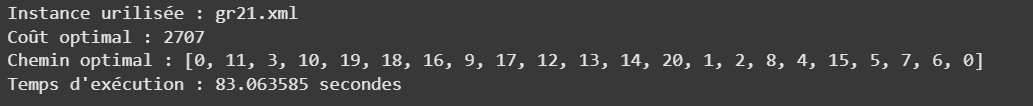

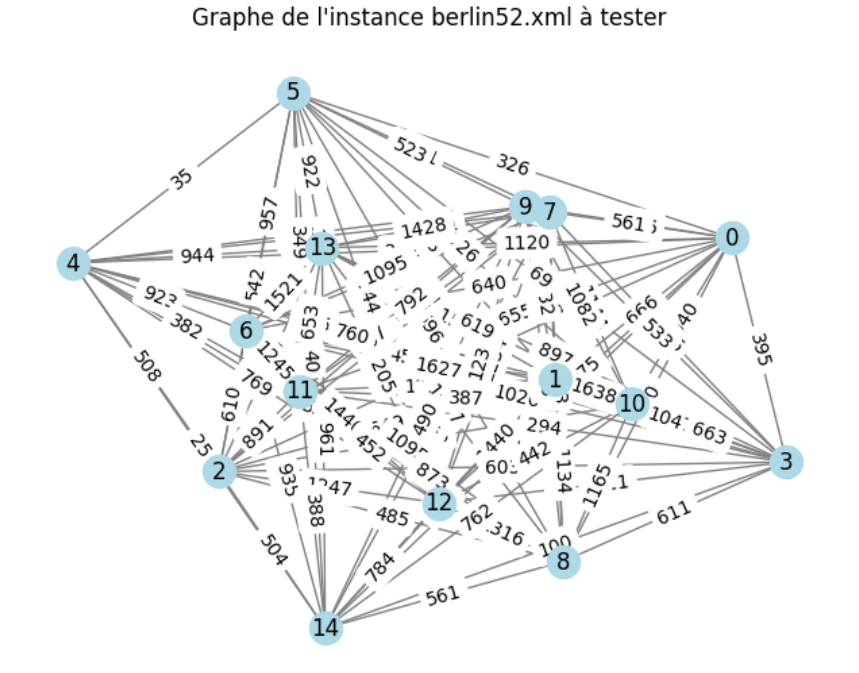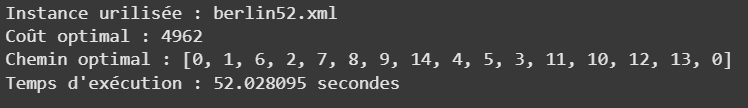

# **TEST avec un fichier test   (*.tsp)**

In [ ]:
#------------------------------------------------------------------------
#Charger l'instance du problème TSP
instance = 'bays29.tsp'
problem = tsplib95.load(instance)
#------------------------------------------------------------------------

#Récupérer la liste des nœuds
nodes = list(problem.get_nodes())
num_nodes = len(nodes)
print(f"Nombre de nœuds : {num_nodes}")

# Initialiser une matrice de distances
distance_matrix_tsp = np.zeros((num_nodes, num_nodes))  # Matrice de distances initialisée à zéro
distance_matrix_tsp = distance_matrix_tsp.astype(int)  # Conversion en entiers

# Remplir la matrice de distances
for i, node_i in enumerate(nodes):
    for j, node_j in enumerate(nodes):
        if i != j:
            # Récupère le poids (distance) entre les nœuds node_i et node_j
            distance_matrix_tsp[i, j] = problem.get_weight(node_i, node_j)
        else:
            # Distance d'un nœud à lui-même est zéro
            distance_matrix_tsp[i, j] = 0

# Extraire un sous-ensemble de la matrice pour les tests
#------------------------------------------------------------------------
n_sub = 17#num_nodes  # Nombre de nœuds à inclure dans le sous-ensemble
print(f"Nombre de nœuds à prendre pour le test : {num_nodes}")
subset = distance_matrix_tsp[:n_sub, :n_sub]  # Sous-ensemble de la matrice
#------------------------------------------------------------------------


distance_matrix_tsp = distance_matrix_tsp.tolist()
subset_matrix_list = subset.tolist()

# Afficher le sous-ensemble de la matrice
print(subset)


Nombre de nœuds : 29
Nombre de nœuds à prendre pour le test : 29
[[  0 107 241 190 124  80 316  76 152 157 283 133 113 297 228 129 348]
 [107   0 148 137  88 127 336 183 134  95 254 180 101 234 175 176 265]
 [241 148   0 374 171 259 509 317 217 232 491 312 280 391 412 349 422]
 [190 137 374   0 202 234 222 192 248  42 117 287  79 107  38 121 152]
 [124  88 171 202   0  61 392 202  46 160 319 112 163 322 240 232 314]
 [ 80 127 259 234  61   0 386 141  72 167 351  55 157 331 272 226 362]
 [316 336 509 222 392 386   0 233 438 254 202 439 235 254 210 187 313]
 [ 76 183 317 192 202 141 233   0 213 188 272 193 131 302 233  98 344]
 [152 134 217 248  46  72 438 213   0 206 365  89 209 368 286 278 360]
 [157  95 232  42 160 167 254 188 206   0 159 220  57 149  80 132 193]
 [283 254 491 117 319 351 202 272 365 159   0 404 176 106  79 161 165]
 [133 180 312 287 112  55 439 193  89 220 404   0 210 384 325 279 415]
 [113 101 280  79 163 157 235 131 209  57 176 210   0 186 117  75 231]
 [297 234 39

# **Visualisation du graphe de l'instance (*.tsp) à tester**

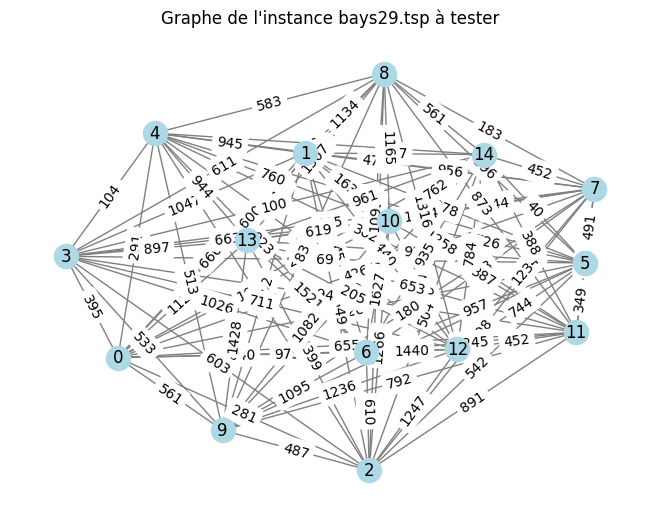

In [ ]:
# Créer un graphe à partir de la matrice de distances
G = nx.Graph()
for i in range(len(sous_ensemble_matrice_liste)):
    for j in range(len(sous_ensemble_matrice_liste[i])):
        if i != j:
            G.add_edge(i, j, weight= sous_ensemble_matrice_liste[i][j])

# Dessiner le graphe
pos = nx.spring_layout(G)  # Positionnement des nœuds
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Graphe de l'instance "+instance+" à tester")
plt.show()

**tester le code implémanté avec la matrice des distances du fichiers (*.tsp)**

In [ ]:
start_time = time.time()
cout_optimal, chemin_optimal = branch_and_bound_tsp_opt(subset_matrix_list)
end_time = time.time()

temps_execution = end_time - start_time

print("Instance urilisée : " + instance)
print("Coût optimal :", cout_optimal)
print("Chemin optimal :", chemin_optimal)
print("Temps d'exécution : {:.6f} secondes".format(temps_execution))

Instance urilisée : bays29.tsp
Coût optimal : 1677
Chemin optimal : [0, 7, 15, 6, 10, 13, 16, 14, 3, 9, 12, 1, 2, 4, 8, 11, 5, 0]
Temps d'exécution : 90.864089 secondes


# **le résultats des fichiers de test (*.tsp) :**



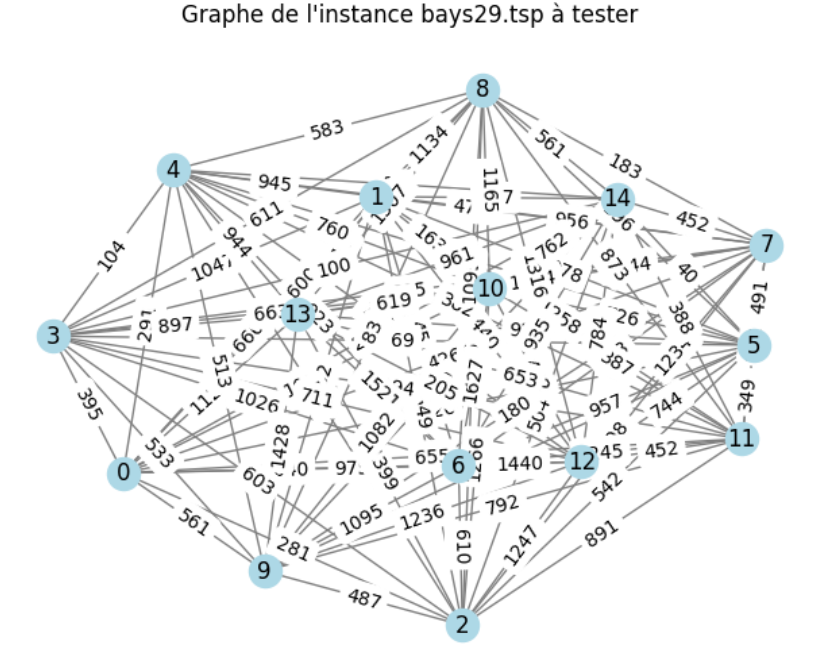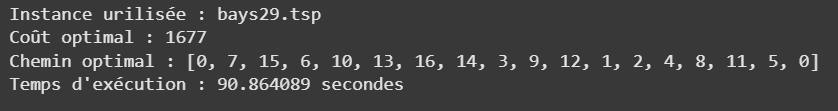

# **DataFrame pour stocker les résultats**

In [ ]:
resultats = pd.DataFrame(columns=["Instance", "Cout_Optimal", "Chemin_Optimal", "Temps_Execution","nombre des noeuds"]) # à executer une seule fois

In [ ]:
new_result = pd.DataFrame({
    "Instance": [instance],
    "Cout_Optimal": [cout_optimal],
    "Chemin_Optimal": [chemin_optimal],
    "Temps_Execution": [temps_execution],
    "nombre des noeuds":[n_sous_ensemble]
})

# Append the new result to the existing DataFrame
resultats = pd.concat([resultats, new_result], ignore_index=True)

print(resultats)

       Instance Cout_Optimal  \
0   burma14.xml         2321   
1   burma14.xml         3114   
2   burma14.xml         3323   
3  berlin52.xml         2313   
4  berlin52.xml         2823   
5  berlin52.xml         4962   

                                      Chemin_Optimal  Temps_Execution  \
0                                    [0, 1, 2, 3, 4]         0.000277   
1                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]         0.060322   
2  [0, 1, 13, 2, 3, 4, 5, 11, 6, 12, 7, 10, 8, 9, 0]        21.046045   
3                                 [0, 4, 3, 2, 1, 0]         0.000225   
4                  [0, 4, 5, 3, 9, 8, 7, 2, 6, 1, 0]         0.044941   
5  [0, 1, 6, 2, 7, 8, 9, 14, 4, 5, 3, 11, 10, 12,...        60.235101   

  nombre des noeuds  
0                 5  
1                10  
2                14  
3                 5  
4                10  
5                15  


In [ ]:
resultats

,Instance,Cout_Optimal,Chemin_Optimal,Temps_Execution,nombre des noeuds
0,burma14.xml,2321,"[0, 1, 2, 3, 4]",0.000277,5
1,burma14.xml,3114,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]",0.060322,10
2,burma14.xml,3323,"[0, 1, 13, 2, 3, 4, 5, 11, 6, 12, 7, 10, 8, 9, 0]",21.046045,14
3,berlin52.xml,2313,"[0, 4, 3, 2, 1, 0]",0.000225,5
4,berlin52.xml,2823,"[0, 4, 5, 3, 9, 8, 7, 2, 6, 1, 0]",0.044941,10
5,berlin52.xml,4962,"[0, 1, 6, 2, 7, 8, 9, 14, 4, 5, 3, 11, 10, 12,...",60.235101,15


# **tableau des résultas du test sur deux fichiers en variant le nombre des noeuds**

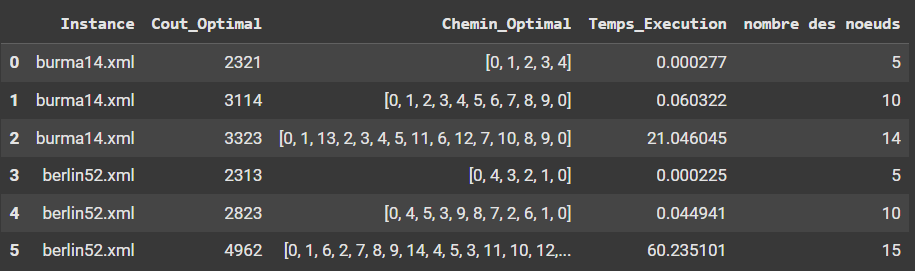

# **Visualisations**

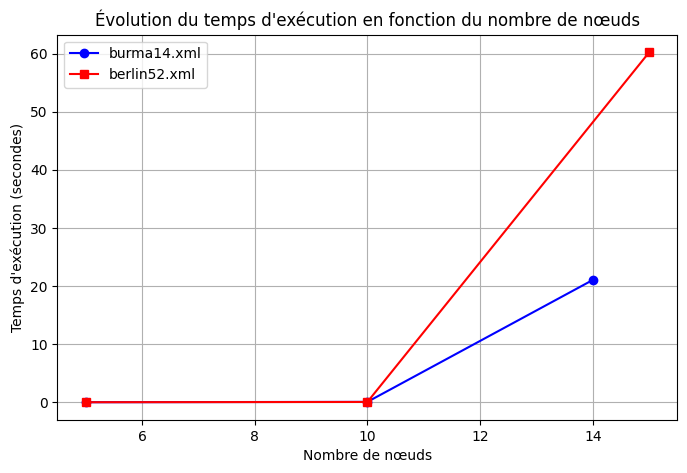

In [ ]:


burma = resultats[resultats["Instance"] == "burma14.xml"]
berlin = resultats[resultats["Instance"] == "berlin52.xml"]

plt.figure(figsize=(8, 5))
plt.plot(burma["nombre des noeuds"], burma["Temps_Execution"], marker='o', linestyle='-', label="burma14.xml", color='blue')
plt.plot(berlin["nombre des noeuds"], berlin["Temps_Execution"], marker='s', linestyle='-', label="berlin52.xml", color='red')


plt.xlabel("Nombre de nœuds")
plt.ylabel("Temps d'exécution (secondes)")
plt.title("Évolution du temps d'exécution en fonction du nombre de nœuds")
plt.legend()
plt.grid(True)


plt.show()


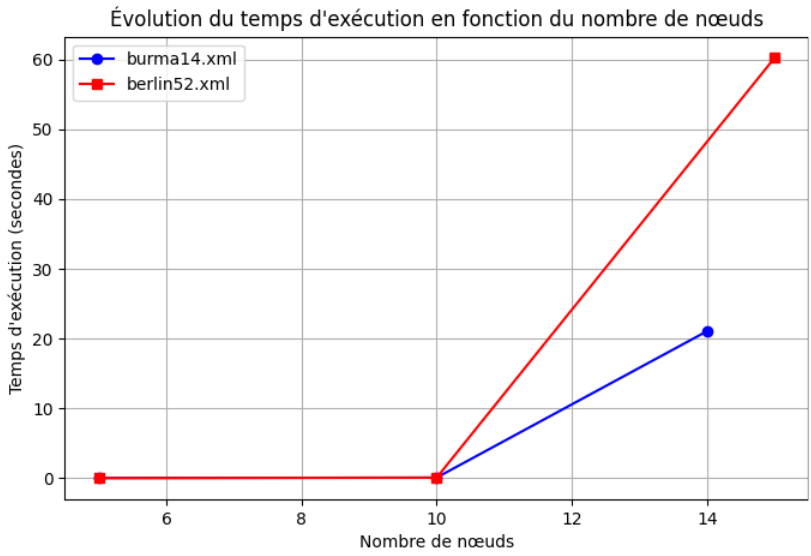